# Modules

In [56]:
%load_ext autoreload
%autoreload 2

import sys

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import torch
from sklearn import datasets, preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
#from sklearn.manifold import TSNE
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report, confusion_matrix)
from sklearn.model_selection import train_test_split

from torch.optim import Adam
from torch.utils.data import DataLoader

from tqdm.autonotebook import tqdm

from models.model import Neural_Net
from dataset_samplers import RandomCorruptSampler, ClassCorruptSampler, SupervisedSampler 
from training import train_contrastive_loss, train_classification
from utils import fix_seed, load_openml_list, preprocess_datasets, fit_one_hot_encoder, get_bootstrapped_targets

import warnings
warnings.filterwarnings('ignore')
print("Disabled warnings!")

seed = 1234
fix_seed(seed)

clf = LogisticRegression()

plot_colors = {
    'no_pretrain': 'k',
    'rand_corr': 'g',
    'cls_corr': 'r',
    'orc_corr': 'b'
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Disabled warnings!
Using device: cuda


# Data

In [57]:
# Toy dataset
# dataset_name = 'breast_cancer'
# data = datasets.load_breast_cancer(as_frame=True)
# data, target = data["data"], data["target"]

# OpenML dataset
datasets = load_openml_list([23, 4538, 6332, 40975])
# select one dataset to run below
dataset = datasets[3]
dataset_name, data, target = dataset

print(f"Loaded dataset: {dataset_name}, with data shape: {data.shape}, and target shape: {target.shape}")
print(f"{dataset_name} dataset has {len(data.select_dtypes(include='category').columns)}/{len(data.columns)} categorical features.")

Loading cmc 23 ..
Dataset with did 23 has 7/9 categorical features.
Loading GesturePhaseSegmentationProcessed 4538 ..
Dataset with did 4538 has 0/32 categorical features.
Loading cylinder-bands 6332 ..


Dataset with did 6332 has 19/37 categorical features.
Loading car 40975 ..
Dataset with did 40975 has 6/6 categorical features.
Loaded dataset: car, with data shape: (1728, 6), and target shape: (1728,)
car dataset has 6/6 categorical features.


In [58]:
tmp_data, test_data, tmp_target, test_targets = train_test_split(
    data, 
    target, 
    test_size=0.2, 
    stratify=target, 
    random_state=seed
)

train_data, valid_data, train_targets, valid_targets = train_test_split(
    tmp_data,
    tmp_target,
    test_size=1/8,
    stratify=tmp_target,
    random_state=seed
)

print(f"# samples: Train: {len(train_data)}; Valid: {len(valid_data)}; Test: {len(test_data)}")
print(f"Train data with type {type(train_data)} and shape {train_data.shape}; Train target with type: {type(train_targets)} and shape {train_targets.shape}")
print(f"Valid data with type {type(valid_data)} and shape {valid_data.shape}; Valid target with type: {type(valid_targets)} and shape {valid_targets.shape}")
print(f"Test data with type {type(test_data)} and shape {test_data.shape}; Test target with type: {type(test_targets)} and shape {test_targets.shape}")

# ensure the splits lead to no class mismatch
assert np.all(np.unique(train_targets).sort() == np.unique(valid_targets).sort()) and \
        np.all(np.unique(train_targets).sort() == np.unique(test_targets).sort())
n_classes = len(np.unique(train_targets))

print(f"The dataset has {n_classes} classes: {np.unique(train_targets)}")

_, train_targets_counts = np.unique(train_targets, return_counts=True)
_, valid_targets_counts = np.unique(valid_targets, return_counts=True)
_, test_targets_counts = np.unique(test_targets, return_counts=True)
print("Count of clases:")
print("Train: ", train_targets_counts)
print("Valid: ", valid_targets_counts)
print("Test: ", test_targets_counts)

# <<<<<<<<<<<<preprocess datasets>>>>>>>>>>>
preprocess_datasets(train_data, valid_data, test_data, normalize_numerical_features=True)
one_hot_encoder = fit_one_hot_encoder(preprocessing.OneHotEncoder(handle_unknown='ignore', drop='if_binary', sparse_output=False), train_data)

# encode targets with label encoding (later will be one-hot encoded in the neural network)
# from here, use the label encoded targets instead of the original potentially string values
print("Original training targets with shape: ", train_targets.shape)

label_encoder_target = preprocessing.LabelEncoder()
train_targets = label_encoder_target.fit_transform(train_targets)
valid_targets = label_encoder_target.transform(valid_targets)
test_targets = label_encoder_target.transform(test_targets)

print("One-hot encoded train targets with shape: ", np.shape(train_targets), "and max value: ", np.max(train_targets), f"({n_classes} classes)")

# samples: Train: 1209; Valid: 173; Test: 346
Train data with type <class 'pandas.core.frame.DataFrame'> and shape (1209, 6); Train target with type: <class 'pandas.core.series.Series'> and shape (1209,)
Valid data with type <class 'pandas.core.frame.DataFrame'> and shape (173, 6); Valid target with type: <class 'pandas.core.series.Series'> and shape (173,)
Test data with type <class 'pandas.core.frame.DataFrame'> and shape (346, 6); Test target with type: <class 'pandas.core.series.Series'> and shape (346,)
The dataset has 4 classes: ['acc' 'good' 'unacc' 'vgood']
Count of clases:
Train:  [269  48 847  45]
Valid:  [ 38   7 121   7]
Test:  [ 77  14 242  13]
No numerical features present! Skip numerical z-score normalization.
Data preprocess finished! Dropped 0 features: []. Normalized numerical features.
Original training targets with shape:  (1209,)
One-hot encoded train targets with shape:  (1209,) and max value:  3 (4 classes)


In [59]:
fraction_withLabel = 0.25
batch_size = 128

n_train_samples_labeled = int(len(train_data)*fraction_withLabel)
# shouldn't index using this variable as it shuffles the ordering
idxes_tmp = np.random.permutation(len(train_data))[:n_train_samples_labeled]
mask_train_labeled = np.zeros(len(train_data), dtype=bool)
mask_train_labeled[idxes_tmp] = True

n_valid_samples_labeled = int(len(valid_data)*fraction_withLabel)
# shouldn't index using this variable as it shuffles the ordering
idxes_tmp = np.random.permutation(len(valid_data))[:n_valid_samples_labeled]
mask_valid_labeled = np.zeros(len(valid_data), dtype=bool)
mask_valid_labeled[idxes_tmp] = True

print(f"Under semi-supervised learning, assume {n_train_samples_labeled}/{len(train_data)} training samples are labeled.")
print(f"Under semi-supervised learning, assume {n_valid_samples_labeled}/{len(valid_data)} validation samples are labeled.")

# Take the labeled subset
# Just use a single sampler, would lead to different shuffled order for training data to different models, shouldn't be any essential difference
supervised_sampler = {}
supervised_sampler['train'] = SupervisedSampler(data=train_data[mask_train_labeled], batch_size=batch_size, target=train_targets[mask_train_labeled])
print("Sampler for supervised training data: ", supervised_sampler['train'])
supervised_sampler['valid'] = SupervisedSampler(data=valid_data[mask_valid_labeled], batch_size=batch_size, target=valid_targets[mask_valid_labeled])
print("Sampler for supervised validation data: ", supervised_sampler['valid'])

# prepare models
models, contrastive_loss_histories, supervised_loss_histories = {}, {}, {}
for key in ['no_pretrain', 'rand_corr', 'cls_corr', 'orc_corr']:
    models[key] = Neural_Net(
        input_dim=one_hot_encoder.transform(train_data).shape[1],  # model expect one-hot encoded input
        emb_dim=256,
        output_dim=n_classes,
        model_device=device    
    ).to(device)
    contrastive_loss_histories[key] = {'train': [], 'valid': []}
    supervised_loss_histories[key] = {'train': [], 'valid': []}

contrastive_optimizers, supervised_optimizers = {}, {}

Under semi-supervised learning, assume 302/1209 training samples are labeled.
Under semi-supervised learning, assume 43/173 validation samples are labeled.
Sampler for supervised training data:  A SupervisedSampler object, with datasize 302.
Sampler for supervised validation data:  A SupervisedSampler object, with datasize 43.
Created a model with input dimension: 21, embedding dimension 256, and output dimension 4!
Created a model with input dimension: 21, embedding dimension 256, and output dimension 4!
Created a model with input dimension: 21, embedding dimension 256, and output dimension 4!
Created a model with input dimension: 21, embedding dimension 256, and output dimension 4!


# Firstly, train the supervised learning model on the labeled subset

In [60]:
key = 'no_pretrain'
supervised_optimizers[key] = Adam(models[key].parameters(), lr=0.001)    
print(f"Supervised learning for {key}...")
train_losses, valid_losses = train_classification(models[key], supervised_sampler, supervised_optimizers[key], one_hot_encoder, device, min_epochs=50, early_stopping=False)
supervised_loss_histories[key]['train'] = train_losses
supervised_loss_histories[key]['valid'] = valid_losses

Supervised learning for no_pretrain...


100%|██████████| 200/200 [00:05<00:00, 36.02it/s]


# User supervised model to obtain pseduo labels

In [63]:
contrastive_samplers = {}

for key in ['rand_corr', 'orc_corr', 'cls_corr']:
    contrastive_samplers[key] = {}

# Random Sampling
# Not using class information in original corruption
contrastive_samplers['rand_corr']['train'] = RandomCorruptSampler(train_data, batch_size) 
contrastive_samplers['rand_corr']['valid'] = RandomCorruptSampler(valid_data, batch_size) 

# Oracle Class Sampling
# Using oracle info on training labels
contrastive_samplers['orc_corr']['train'] = ClassCorruptSampler(train_data, batch_size, train_targets) 
contrastive_samplers['orc_corr']['valid'] = ClassCorruptSampler(valid_data, batch_size, valid_targets)

# Predicted Class Sampling
bootstrapped_train_targets = get_bootstrapped_targets( \
    train_data, train_targets, models['no_pretrain'], mask_train_labeled, one_hot_encoder, device)
contrastive_samplers['cls_corr']['train'] = ClassCorruptSampler(train_data, batch_size, bootstrapped_train_targets) 
bootstrapped_valid_targets = get_bootstrapped_targets( \
    valid_data, valid_targets, models['no_pretrain'], mask_valid_labeled, one_hot_encoder, device)
contrastive_samplers['cls_corr']['valid'] = ClassCorruptSampler(valid_data, batch_size, bootstrapped_valid_targets)

for key in ['rand_corr', 'orc_corr', 'cls_corr']:
    for split in ['train', 'valid']:
        print(f"{key} sampler for contrastive {split} data: ", contrastive_samplers[key][split])

rand_corr sampler for contrastive train data:  A RandomCorruptSampler object, with datasize 1209.
rand_corr sampler for contrastive valid data:  A RandomCorruptSampler object, with datasize 173.
orc_corr sampler for contrastive train data:  A ClassCorruptSampler object, with datasize 1209.
orc_corr sampler for contrastive valid data:  A ClassCorruptSampler object, with datasize 173.
cls_corr sampler for contrastive train data:  A ClassCorruptSampler object, with datasize 1209.
cls_corr sampler for contrastive valid data:  A ClassCorruptSampler object, with datasize 173.


# Training

Contrastive learning for rand_corr sampling....


100%|██████████| 1000/1000 [03:03<00:00,  5.45it/s]


Contrastive learning for cls_corr sampling....


100%|██████████| 1000/1000 [03:14<00:00,  5.13it/s]


Contrastive learning for orc_corr sampling....


100%|██████████| 1000/1000 [03:18<00:00,  5.05it/s]


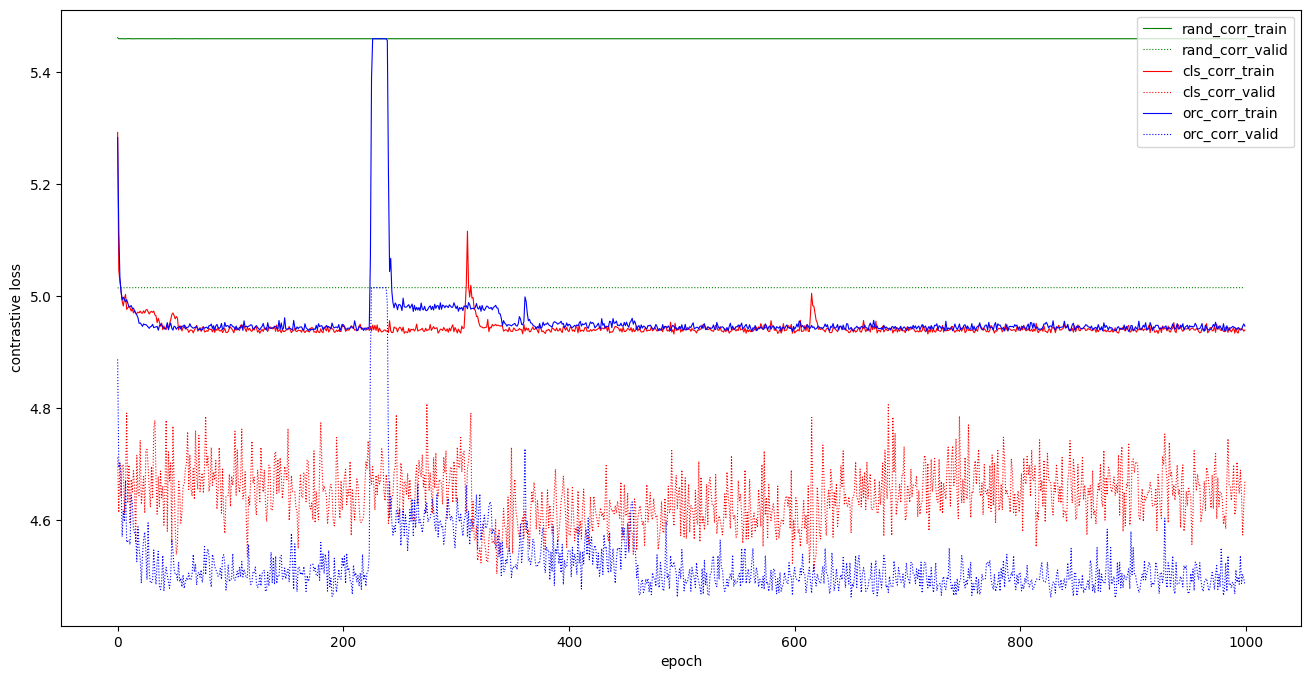

Supervised learning for rand_corr...


100%|██████████| 200/200 [00:03<00:00, 55.15it/s]


Supervised learning for cls_corr...


100%|██████████| 200/200 [00:03<00:00, 55.52it/s]


Supervised learning for orc_corr...


100%|██████████| 200/200 [00:03<00:00, 55.32it/s]


Model saved at trained_models/car_no_pretrain.pt!
Model saved at trained_models/car_rand_corr.pt!
Model saved at trained_models/car_cls_corr.pt!
Model saved at trained_models/car_orc_corr.pt!


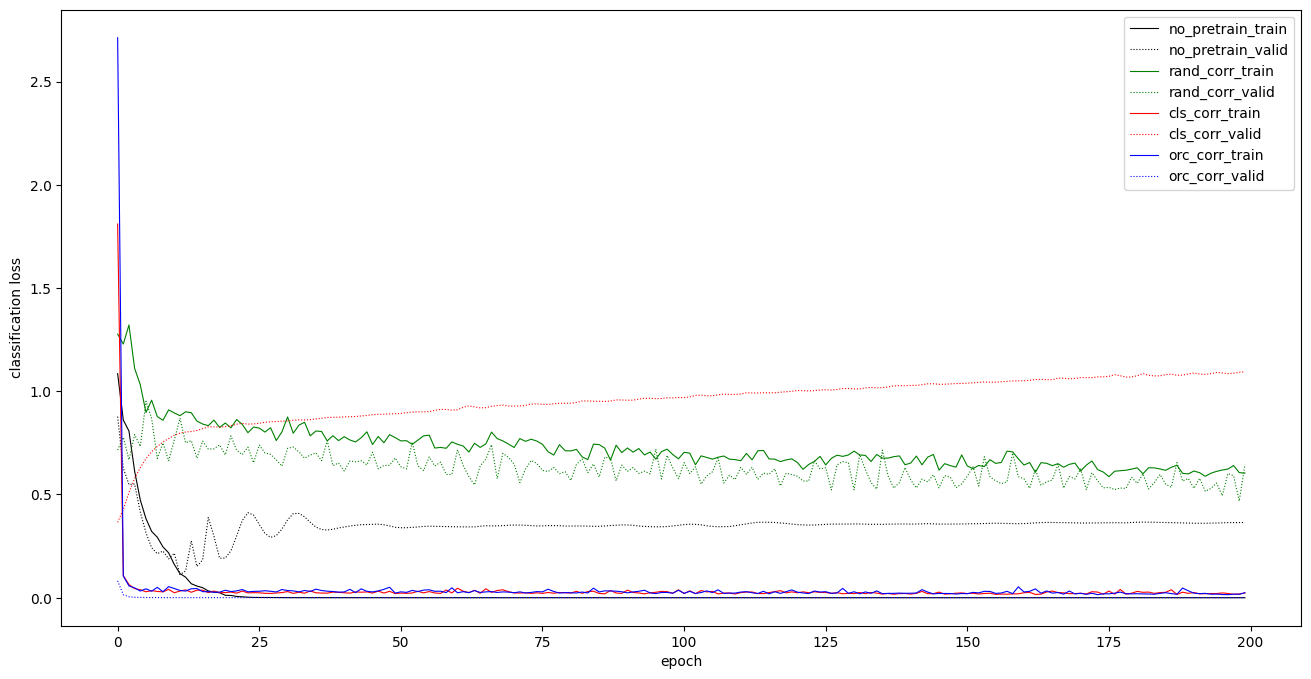

In [64]:
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    contrastive_optimizers[key] = Adam(models[key].parameters(), lr=0.001)
    print(f"Contrastive learning for {key} sampling....")
    train_losses, valid_losses = train_contrastive_loss(models[key], contrastive_samplers[key], contrastive_optimizers[key], one_hot_encoder, device, min_epochs=100, early_stopping=False)
    contrastive_loss_histories[key]['train'] = train_losses
    contrastive_loss_histories[key]['valid'] = valid_losses

# plot contrastive learning losses
fig, ax = plt.subplots(figsize=(16, 8))
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    ax.plot(contrastive_loss_histories[key]['train'], label=f'{key}_train', linewidth=0.8, color=plot_colors[key])
    ax.plot(contrastive_loss_histories[key]['valid'], label=f'{key}_valid', linewidth=0.8, linestyle=':', color=plot_colors[key])
ax.set_xlabel("epoch")
ax.set_ylabel("contrastive loss")
ax.legend()
plt.show()

# fine tune the pre-trained models on the down-stream supervised learning task
for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    models[key].freeze_encoder()
    supervised_optimizers[key] = Adam(filter(lambda p: p.requires_grad, models[key].parameters()), lr=0.001)
    supervised_loss_histories[key] = {'train': [], 'valid': []}

for key in ['rand_corr', 'cls_corr', 'orc_corr']:
    print(f"Supervised learning for {key}...")
    train_losses, valid_losses = train_classification(models[key], supervised_sampler, supervised_optimizers[key], one_hot_encoder, device, min_epochs=50, early_stopping=False)
    supervised_loss_histories[key]['train'] = train_losses
    supervised_loss_histories[key]['valid'] = valid_losses

# visualize loss
fig, ax = plt.subplots(figsize=(16, 8))
for key in ['no_pretrain', 'rand_corr', 'cls_corr', 'orc_corr']:
    ax.plot(supervised_loss_histories[key]['train'], label=f'{key}_train', linewidth=0.8, color=plot_colors[key])
    ax.plot(supervised_loss_histories[key]['valid'], label=f'{key}_valid', linewidth=0.8, linestyle=':', color=plot_colors[key])
ax.set_xlabel("epoch")
ax.set_ylabel("classification loss")
ax.legend()

# save the models
for key in ['no_pretrain', 'rand_corr', 'cls_corr', 'orc_corr']:
    model_filename = f'trained_models/{dataset_name}_{key}.pt'
    torch.save(models[key].state_dict(), model_filename)
    print(f"Model saved at {model_filename}!")


# [Optional] Load previously trained models and their losses

In [46]:
for key in ['pre_train', 'rand_corr', 'cls_corr', 'orc_corr']:
    model_filename = f'trained_models/{dataset_name}_{key}.pt'
    models[key].load_state_dict(torch.load(model_filename))
    print(f"Model loaded from {model_filename}!")

Model loaded from trained_models/car_rand_corr.pt!
Model loaded from trained_models/car_cls_corr.pt!
Model loaded from trained_models/car_orc_corr.pt!


# Evaluation on down-stream classification task

In [65]:
# Test the trained classification models
for key in ['no_pretrain', 'rand_corr', 'cls_corr', 'orc_corr']:
    models[key].eval()
    with torch.no_grad():
        test_prediction_logits = models[key].get_classification_prediction_logits(torch.tensor(one_hot_encoder.transform(test_data), dtype=torch.float32).to(device)).cpu().numpy()
        test_predictions = np.argmax(test_prediction_logits,axis=1)
        print(f"{key} predictions: ", test_predictions[:30], "...")
        print(f"{key} Classification report:")
        print(classification_report(test_targets, test_predictions))
        print("Classification accuracy: {:.3f} %".format(np.mean(test_predictions==test_targets)*100))
        print("==========================================================================")


no_pretrain predictions:  [2 2 2 2 2 0 0 2 2 2 0 0 2 2 0 0 2 1 2 2 2 2 2 2 1 2 0 0 0 2] ...
no_pretrain Classification report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        77
           1       0.61      0.79      0.69        14
           2       0.99      0.95      0.97       242
           3       0.64      0.54      0.58        13

    accuracy                           0.92       346
   macro avg       0.77      0.80      0.78       346
weighted avg       0.93      0.92      0.93       346

Classification accuracy: 92.486 %
rand_corr predictions:  [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2] ...
rand_corr Classification report:
              precision    recall  f1-score   support

           0       0.64      0.09      0.16        77
           1       0.00      0.00      0.00        14
           2       0.72      1.00      0.84       242
           3       0.00      0.00      0.00        13

    accur

# Visualize embeddings (also view embeddings for purely supervised learning algorithm without pre-training)

In [66]:
# get embeddings for training and test set
train_embeddings, test_embeddings = {}, {}
for key in ['no_pretrain', 'rand_corr', 'cls_corr', 'orc_corr']:
    models[key].eval()
    with torch.no_grad():
        train_embeddings[key] = models[key].get_middle_embedding(torch.tensor(one_hot_encoder.transform(train_data), dtype=torch.float32).to(device)).cpu().numpy()
        test_embeddings[key] = models[key].get_middle_embedding(torch.tensor(one_hot_encoder.transform(test_data), dtype=torch.float32).to(device)).cpu().numpy()

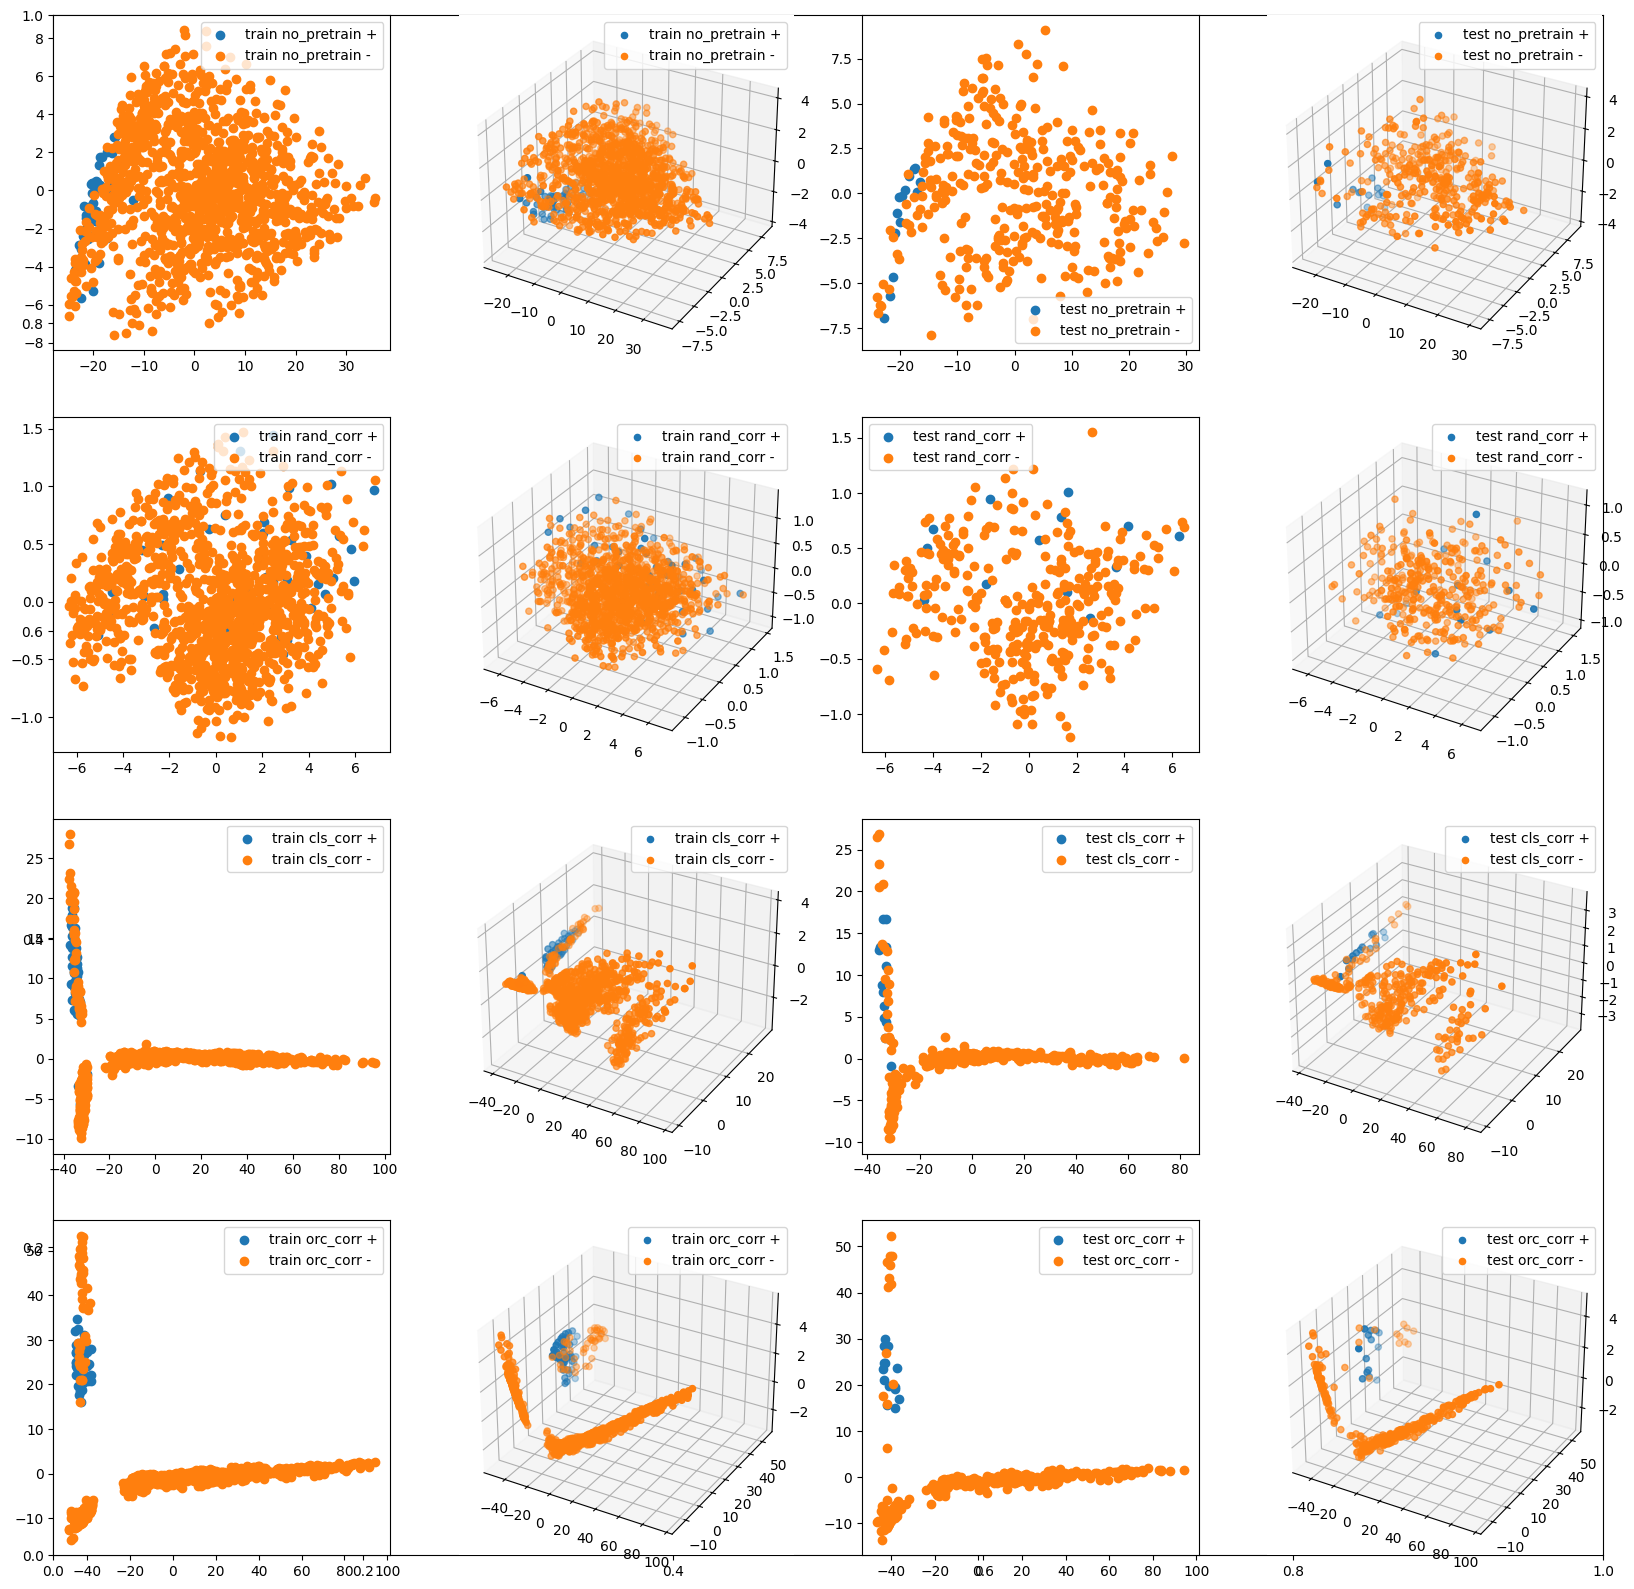

In [67]:
fig, axes = plt.subplots(figsize=(20, 20))
# Visualzie using PCA (which supports same basis from training to testing)
pca_2D = PCA(n_components=2, copy=True)
pca_3D = PCA(n_components=3, copy=True)

for row_id, key in enumerate(['no_pretrain', 'rand_corr', 'cls_corr', 'orc_corr']):
    reduced_2D = pca_2D.fit_transform(train_embeddings[key])
    reduced_3D = pca_3D.fit_transform(train_embeddings[key])
    positive = train_targets == 1
    ax = fig.add_subplot(4,4,row_id*4+1)
    ax.scatter(reduced_2D[positive, 0], reduced_2D[positive, 1], label=f"train {key} +")
    ax.scatter(reduced_2D[~positive, 0], reduced_2D[~positive, 1], label=f"train {key} -")
    ax.legend()
    ax = fig.add_subplot(4,4,row_id*4+2, projection='3d')
    ax.scatter(reduced_3D[positive, 0], reduced_3D[positive, 1], reduced_3D[positive, 2], label=f"train {key} +")
    ax.scatter(reduced_3D[~positive, 0], reduced_3D[~positive, 1], reduced_3D[~positive,2], label=f"train {key} -")
    ax.legend()

    reduced_2D = pca_2D.fit_transform(test_embeddings[key])
    reduced_3D = pca_3D.fit_transform(test_embeddings[key])
    positive = test_targets == 1
    ax = fig.add_subplot(4,4,row_id*4+3)
    ax.scatter(reduced_2D[positive, 0], reduced_2D[positive, 1], label=f"test {key} +")
    ax.scatter(reduced_2D[~positive, 0], reduced_2D[~positive, 1], label=f"test {key} -")
    ax.legend()
    ax = fig.add_subplot(4,4,row_id*4+4, projection='3d')
    ax.scatter(reduced_3D[positive, 0], reduced_3D[positive, 1], reduced_3D[positive, 2], label=f"test {key} +")
    ax.scatter(reduced_3D[~positive, 0], reduced_3D[~positive, 1], reduced_3D[~positive,2], label=f"test {key} -")
    ax.legend()

plt.show()